In [18]:
import json

import networkx as nx
import numpy as np
import pandas as pd
from shapely.geometry import LineString, MultiLineString, Point

import matplotlib.pyplot as plt

from railroad import load_graph, plot_node_graph, save_graph, test_road_graph
from utils import generate_lattice_arrays, print_graph_info, compute_length

In [19]:
with open("../data/standard_variables.json", "r") as f:
    standard_variables_data = json.load(f)


xlim = (standard_variables_data['map_limits']['west'],
        standard_variables_data['map_limits']['east'])
ylim = (standard_variables_data['map_limits']['south'],
        standard_variables_data['map_limits']['north'])
print(xlim, ylim)

standard_variables_data

(-22.083955, -21.640345) (64.033992, 64.188968)


{'map_limits': {'north': 64.188968,
  'south': 64.033992,
  'east': -21.640345,
  'west': -22.083955},
 'grid_size': {'unit': 'meters', 'value': 100},
 'standard_variables': {'cutoff_radius': {'unit': 'meters', 'value': 400}}}

In [20]:
road_graph = load_graph('../data/simple_railroads.json')

In [21]:
for node_from, node_to, data in road_graph.edges(data=True):
    if isinstance(data['name'], list):
        data['name'] = '-'.join(filter(None, data['name']))

In [22]:
print_graph_info(road_graph)

Undirected has 631 nodes and 638 edges
+----------------------+
Nodes
+----------------------+
*** Node: 1848219055 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.81 64.086)>, 'year': 2025, 'is_station': True}
*** Node: 2377573222 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.81 64.086)>, 'year': 2025}
*** Node: 2376559462 ***
  Data: {'street_count': 4, 'geometry': <POINT (-21.811 64.087)>, 'year': 2025}
*** Node: 6275519667 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.812 64.087)>, 'year': 2025}
*** Node: 464514835 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.812 64.087)>, 'year': 2025}
*** Node: 255374230 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.812 64.087)>, 'year': 2025}
+----------------------+
Edges
+----------------------+
*** Edge: 1848219055 -> 2377573222 ***
  Data: {'year': 2025, 'name': 'Elliðahvammsvegur', 'length': 0.06590414747782208, 'geometry': <LINESTRING (-21.81 64.086, -21.81 64.086, -21.81 64.086, -21.81 64.0

In [23]:
def combine_ordered_linestrings(linestrings):
    """
    Combine a list of ordered LineStrings into a single LineString, ensuring proper orientation.

    Args:
        linestrings (list of LineString): The input LineStrings, where each LineString is connected to the next one.

    Returns:
        LineString: A single combined LineString.
    """

    # Start with the first LineString
    if linestrings[0].coords[0] in (linestrings[1].coords[0], linestrings[1].coords[-1]):
        combined_coords = list(linestrings[0].coords)[::-1]
    else:
        combined_coords = list(linestrings[0].coords)

    for i in range(1, len(linestrings)):
        current_coords = list(linestrings[i].coords)

        # Check the connection point and reverse if necessary
        if combined_coords[-1] == current_coords[-1]:
            combined_coords.extend(current_coords[::-1][1:])
        elif combined_coords[-1] == current_coords[0]:
            combined_coords.extend(current_coords[1:])

        else:
            raise ValueError(
                f"Segments {i - 1} and {i} are not connected properly: {current_coords[0] =}, {current_coords[-1] =}, {combined_coords[0] =}, {combined_coords[-1] =}")

    return LineString(combined_coords)


def edge_data_function(chain_edges):
    """
    Aggregates data for the new edge from a chain of edges.

    Parameters:
        chain_edges: list of tuples
            List of edges in the form (node1, node2, data), where data is a dictionary of edge attributes.

    Returns:
        dict: Aggregated edge attributes for the new edge.
    """
    names = []
    years = []
    lengths = 0.0
    geometries = []

    for data in chain_edges:
        names.append(data.get('name', ''))
        years.append(data.get('year', float('inf')))
        lengths += data.get('length', 0.0)
        geometries.append(data.get('geometry'))

    assert all(isinstance(name, str)
               for name in names), "Names are not strings"

    combined_name = '-'.join(filter(None, set(names)))

    # Get minimum year
    min_year = min(years)

    combined_geometry = combine_ordered_linestrings(geometries)

    # Assert the resulting geometry is a LINESTRING
    assert isinstance(combined_geometry,
                      LineString), "Combined geometry is not a LINESTRING"

    return {
        'name': combined_name,
        'year': min_year,
        'length': lengths,
        'geometry': combined_geometry
    }

In [24]:
def simplify_chains_to_edges(graph, edge_data_function):
    """
    Simplifies a graph by transforming edge-node-edge sequences into a single edge,
    respecting the constraint that nodes with 'is_station': True cannot be simplified.

    Parameters:
        graph: nx.Graph
            The input undirected graph.
        edge_data_function: callable
            A function that takes a list of edges and returns the data for the new edge.

    Returns:
        nx.Graph: The simplified graph.
    """
    simplified_graph = graph.copy()

    # Find all nodes with degree 2 that are not stations
    available_nodes = set(
        node for node in simplified_graph.nodes()
        if simplified_graph.degree[node] == 2 and not simplified_graph.nodes[node].get('is_station', False)
    )

    def pick_neighbor(G, node, chain, mode='forward'):
        if len(chain) == 1:
            neighbors = list(simplified_graph.neighbors(node))
            if mode == 'forward':
                return neighbors[0] if neighbors[1] > neighbors[0] else neighbors[1]
            else:
                return neighbors[0] if neighbors[1] < neighbors[0] else neighbors[1]
        assert G.degree[node] == 2, "Node must have degree 2"
        neighbors = list(simplified_graph.neighbors(node))
        return neighbors[0] if neighbors[1] in chain else neighbors[1]

    def grow_chain(direction, node_chain, available_nodes):
        """
        Grows a chain from the given node in the specified direction.

        Parameters:
            direction: str
                Either 'forward' or 'backward'.
            chain: list
                The current chain being grown.

        Returns:
            list: The updated chain with nodes added in the specified direction.
        """
        current_node = node_chain[-1] if direction == 'forward' else node_chain[0]

        while True:

            next_node = pick_neighbor(
                simplified_graph, current_node, node_chain, mode=direction)

            # Stop growing if the next node can't be part of a chain
            if next_node not in available_nodes or next_node in node_chain:
                break

            # Add node to chain
            if direction == 'forward':
                node_chain.append(next_node)
            elif direction == 'backward':
                node_chain.insert(0, next_node)

            current_node = next_node

        return node_chain

    while available_nodes:
        node = list(available_nodes)[0]  # Pick a node to process
        # print(f"Processing node: {node}")

        # Grow chains in both directions
        full_chain = grow_chain('forward', [node], available_nodes)
        full_chain = grow_chain('backward', full_chain, available_nodes)

        # print(f"  Full chain for node {node}: {full_chain}")

        if len(full_chain) == 1:
            endpoints = list(simplified_graph.neighbors(full_chain[0]))
        else:
            endpoints = pick_neighbor(simplified_graph, full_chain[0], full_chain), pick_neighbor(
                simplified_graph, full_chain[-1], full_chain)

        # Collect edges from the chain
        chain_edges = [(endpoints[0], full_chain[0])]+[
            (full_chain[i], full_chain[i + 1]) for i in range(len(full_chain) - 1)
        ]+[(full_chain[-1], endpoints[1])]

        chain_edges_data = [simplified_graph[edge[0]][edge[1]]
                            for edge in chain_edges]

        assert all(node in available_nodes for node in full_chain)
        assert endpoints[0] not in available_nodes
        assert endpoints[1] not in available_nodes
        assert endpoints[0] != endpoints[1]
        assert endpoints[0] not in full_chain
        assert endpoints[1] not in full_chain

        # print(
        #     f"  Chain start neighbors: {list(simplified_graph.neighbors(full_chain[0]))}")
        # print(
        #     f"    Creating new edge between {endpoints[0]} and {endpoints[1]}.")
        new_edge_data = edge_data_function(chain_edges_data)
        # print(f"    New edge data: {new_edge_data}")
        assert 'geometry' in new_edge_data and isinstance(
            new_edge_data['geometry'], LineString)
        assert endpoints[0] in simplified_graph.nodes(
        ) and endpoints[1] in simplified_graph.nodes()

        assert all('geometry' in data for node,
                   data in simplified_graph.nodes(data=True))

        available_nodes -= set(full_chain)
        simplified_graph.remove_nodes_from(full_chain)

        new_origin_id = endpoints[0]

        new_edge_data['origin_node'] = new_origin_id

        simplified_graph.add_edge(
            endpoints[0], endpoints[1], **new_edge_data)

    return simplified_graph

In [25]:
simplified_G = simplify_chains_to_edges(road_graph, edge_data_function)

In [26]:
for node, data in road_graph.nodes(data=True):
    if 'geometry' not in data:
        print(f"Node {node} has no geometry")
        print(data)

In [27]:
for node, data in simplified_G.nodes(data=True):
    if 'geometry' not in data:
        print(f"Node {node} has no geometry")
        print(data)

In [28]:
for id_in, id_out, data in simplified_G.edges(data=True):
    origin_id = data['origin_node']
    assert origin_id in (id_in, id_out)
    if not np.all(np.equal(simplified_G.nodes[origin_id]['geometry'].coords, data['geometry'].coords[0])):
        print(
            f"{np.equal(simplified_G.nodes[origin_id]['geometry'].coords , data['geometry'].coords[0]) = }")
        print(
            f"{simplified_G.nodes[origin_id]['geometry'].coords[0]} != {data['geometry'].coords[0]}")

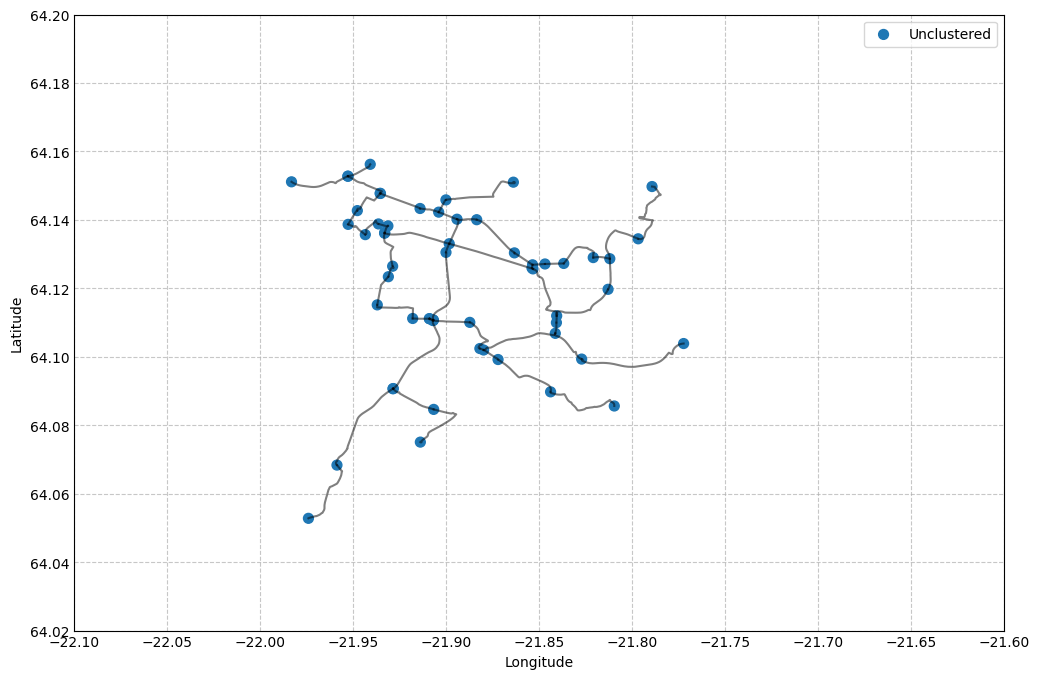

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [29]:
plot_node_graph(simplified_G, xlim=xlim, ylim=ylim)

In [30]:
simplified_G.edges[35786587, 1232404889]['year'] = 2029

In [31]:
test_road_graph(simplified_G)

In [32]:
for u, v, data in simplified_G.edges(data=True):
    if 'geometry' in data:
        data['length'] = compute_length(data['geometry'])
    else:
        raise ValueError(f"Edge {u, v} has no geometry")

In [33]:
save_graph(simplified_G, '../data/simplified_railroads.json')

In [34]:
score_df = pd.read_csv("../data/lattice_normalized_score.csv")
score_df['poi_score'] = score_df['total_normalized_score'] * 100
display(score_df)
unique_latitudes = score_df['latitude'].unique()
unique_longitudes = score_df['longitude'].unique()

x_lattice_array = sorted(unique_longitudes)
y_lattice_array = sorted(unique_latitudes)

print("Unique Latitudes:", len(unique_latitudes))
print("Unique Longitudes:", len(unique_longitudes))

dfs = {'poi_score': score_df}

point_index   latitude  longitude  total_normalized_score  poi_score
0                 0  64.033992 -22.083955                     0.0        0.0
1                 1  64.033992 -22.083057                     0.0        0.0
2                 2  64.033992 -22.082158                     0.0        0.0
3                 3  64.033992 -22.081260                     0.0        0.0
4                 4  64.033992 -22.080362                     0.0        0.0
...             ...        ...        ...                     ...        ...
195619       195619  64.188920 -21.644679                     0.0        0.0
195620       195620  64.188920 -21.643781                     0.0        0.0
195621       195621  64.188920 -21.642882                     0.0        0.0
195622       195622  64.188920 -21.641984                     0.0        0.0
195623       195623  64.188920 -21.641086                     0.0        0.0

[195624 rows x 5 columns]

Unique Latitudes: 396
Unique Longitudes: 494


In [35]:
population_df = pd.read_csv("../data/lattice_population_proximity.csv")
population_df['population_score_2025'] = population_df['total_population_2025']*0.001
population_df['population_score_2029'] = population_df['total_population_2029']*0.001
population_df['population_score_2030'] = population_df['total_population_2030']*0.001
display(population_df)
# dfs['total_population_2025'] = dfs['total_population_2029'] = dfs['total_population_2030'] = population_df
dfs['population_score_2025'] = dfs['population_score_2029'] = dfs['population_score_2030'] = population_df

point_index   latitude  longitude  total_population_2025  \
0                 0  64.033992 -22.083955               0.000000   
1                 1  64.033992 -22.083057               0.000000   
2                 2  64.033992 -22.082158               0.000000   
3                 3  64.033992 -22.081260               0.000000   
4                 4  64.033992 -22.080362               0.000000   
...             ...        ...        ...                    ...   
195619       195619  64.188920 -21.644679               0.000000   
195620       195620  64.188920 -21.643781               0.455864   
195621       195621  64.188920 -21.642882               0.455864   
195622       195622  64.188920 -21.641984               0.455864   
195623       195623  64.188920 -21.641086               0.455864   

        total_population_2029  total_population_2030  population_score_2025  \
0                    0.000000               0.000000               0.000000   
1                    0.000000               0.000000               0.000000   
2                    0.000000               0.000000               0.000000   
3                    0.000000               0.000000               0.000000   
4                    0.000000               0.000000               0.000000   
...                       ...                    ...                    ...   
195619               0.000000               0.000000               0.000000   
195620               0.455864               0.455864               0.000456   
195621               0.455864               0.455864               0.000456   
195622               0.455864               0.455864               0.000456   
195623               0.455864               0.455864               0.000456   

        population_score_2029  population_score_2030  
0                    0.000000               0.000000  
1                    0.000000               0.000000  
2                    0.000000               0.000000  
3                    0.000000               0.000000  
4                    0.000000               0.000000  
...                       ...                    ...  
195619               0.000000               0.000000  
195620               0.000456               0.000456  
195621               0.000456               0.000456  
195622               0.000456               0.000456  
195623               0.000456               0.000456  

[195624 rows x 9 columns]

In [36]:
final_df = pd.read_csv("../data/lattice_final_score.csv")
display(final_df)
dfs['final_score'] = final_df

point_index   latitude  longitude  final_score
0                 0  64.033992 -22.083955     0.000000
1                 1  64.033992 -22.083057     0.000000
2                 2  64.033992 -22.082158     0.000000
3                 3  64.033992 -22.081260     0.000000
4                 4  64.033992 -22.080362     0.000000
...             ...        ...        ...          ...
195619       195619  64.188920 -21.644679     0.000000
195620       195620  64.188920 -21.643781     0.001368
195621       195621  64.188920 -21.642882     0.001368
195622       195622  64.188920 -21.641984     0.001368
195623       195623  64.188920 -21.641086     0.001368

[195624 rows x 4 columns]

In [37]:
parking_df = pd.read_csv("../data/lattice_parking_capacity.csv")
parking_df['parking_score'] = 0.1*0.001*parking_df['total_capacity']
display(parking_df)
dfs['parking_score'] = parking_df

point_index   latitude  longitude  total_capacity  parking_score
0                 0  64.033992 -22.083955             0.0            0.0
1                 1  64.033992 -22.083057             0.0            0.0
2                 2  64.033992 -22.082158             0.0            0.0
3                 3  64.033992 -22.081260             0.0            0.0
4                 4  64.033992 -22.080362             0.0            0.0
...             ...        ...        ...             ...            ...
195619       195619  64.188920 -21.644679             0.0            0.0
195620       195620  64.188920 -21.643781             0.0            0.0
195621       195621  64.188920 -21.642882             0.0            0.0
195622       195622  64.188920 -21.641984             0.0            0.0
195623       195623  64.188920 -21.641086             0.0            0.0

[195624 rows x 5 columns]

In [38]:
def find_closest_point_id(x, y, x_coords, y_coords):
    """
    Finds the ID of the closest point in the grid for a given x and y coordinate,
    without requiring a DataFrame.

    Parameters:
    - x: float, the x-coordinate (longitude)
    - y: float, the y-coordinate (latitude)
    - x_coords: sorted array of unique longitudes
    - y_coords: sorted array of unique latitudes

    Returns:
    - closest_id: int, the ID of the closest point in the flattened meshgrid
    """
    # Find the indices of the closest x and y coordinates
    x_idx = np.argmin(np.abs(np.array(x_coords) - x))
    y_idx = np.argmin(np.abs(np.array(y_coords) - y))

    # Convert 2D grid indices to 1D index
    num_x = len(x_coords)
    closest_id = y_idx * num_x + x_idx

    return closest_id


# Example usage
x_lattice_array = sorted(score_df['longitude'].unique())
y_lattice_array = sorted(score_df['latitude'].unique())
test_x = -21.85  # Example longitude
test_y = 64.034   # Example latitude

closest_id = find_closest_point_id(
    test_x, test_y, x_lattice_array, y_lattice_array)
print(f"Closest point ID for ({test_x}, {test_y}): {closest_id}")
display(score_df.loc[closest_id])

Closest point ID for (-21.85, 64.034): 260


point_index               260.000000
latitude                   64.033992
longitude                 -21.850393
total_normalized_score      0.000000
poi_score                   0.000000
Name: 260, dtype: float64

In [39]:
def find_closest_score(point, variable_to_df_dict, x_lattice_array, y_lattice_array):
    """
    Finds the scores for the closest grid point to the given point for all variables.

    Parameters:
    - point: shapely.geometry.Point, the point for which the score is to be found
    - variable_to_df_dict: dict, a dictionary where keys are variable names and values are DataFrames
      containing the grid data with 'latitude', 'longitude', and respective variable scores
    - x_lattice_array: sorted array of unique longitudes from the grid
    - y_lattice_array: sorted array of unique latitudes from the grid

    Returns:
    - scores: dict, a dictionary where keys are variable names and values are the scores of the closest grid point
    """
    # Extract coordinates
    x, y = point.x, point.y

    closest_id = find_closest_point_id(x, y, x_lattice_array, y_lattice_array)

    scores = {}

    # Fetch scores from the DataFrames for each variable
    for variable, df in variable_to_df_dict.items():
        row = df.loc[closest_id]
        scores[variable] = float(row[variable])

    return scores


def assign_scores_to_edges(graph, variable_to_df_dict, x_lattice_array, y_lattice_array, step=0.05):
    """
    Assigns scores for multiple variables to each edge of the graph for interpolated points.

    Parameters:
    - graph: NetworkX graph where edges have geometry (LineString)
    - variable_to_df_dict: dict, a dictionary where keys are variable names and values are DataFrames
      containing the grid data with 'latitude', 'longitude', and respective variable scores
    - x_lattice_array: sorted array of unique longitudes from the grid
    - y_lattice_array: sorted array of unique latitudes from the grid
    - step: float, the step size in km for sampling along each edge
    """

    for u, v, data in graph.edges(data=True):
        # Ensure geometry exists
        if 'geometry' not in data or not isinstance(data['geometry'], LineString):
            continue

        line = data['geometry']
        score_data = []

        # Sample points every 'step' meters along the line
        distance = 0
        length = data['length']
        while distance <= length:
            point = line.interpolate(line.length * distance / data['length'])
            interpolation_value = distance / data['length']
            scores = find_closest_score(
                point, variable_to_df_dict, x_lattice_array, y_lattice_array
            )

            # Add interpolation data for this point
            score_data.append({
                'distance_from_start': distance,
                'coordinate': (point.x, point.y),
                'interpolation_value': interpolation_value,
                'scores': scores
            })
            distance += step

        data['score_data'] = score_data

    return graph

In [40]:
G = assign_scores_to_edges(simplified_G, dfs,
                           x_lattice_array, y_lattice_array)

In [41]:
print_graph_info(G)

Undirected has 58 nodes and 63 edges
+----------------------+
Nodes
+----------------------+
*** Node: 1848219055 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.81 64.086)>, 'year': 2025, 'is_station': True}
*** Node: 602729079 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.844 64.09)>, 'year': 2025, 'is_station': True}
*** Node: 111465687 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.872 64.099)>, 'year': 2025, 'is_station': True}
*** Node: 2320789566 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.88 64.102)>, 'year': 2025}
*** Node: 2320771865 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.882 64.102)>, 'year': 2025, 'is_station': True}
*** Node: 2328470640 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.887 64.11)>, 'year': 2025, 'is_station': True}
+----------------------+
Edges
+----------------------+
*** Edge: 1848219055 -> 602729079 ***
  Data: {'name': 'Arnarnesvegur-Salavegur-Kóratorg-Rjúpnavegur-Arnarnesvegur-Rjúpnavegur-

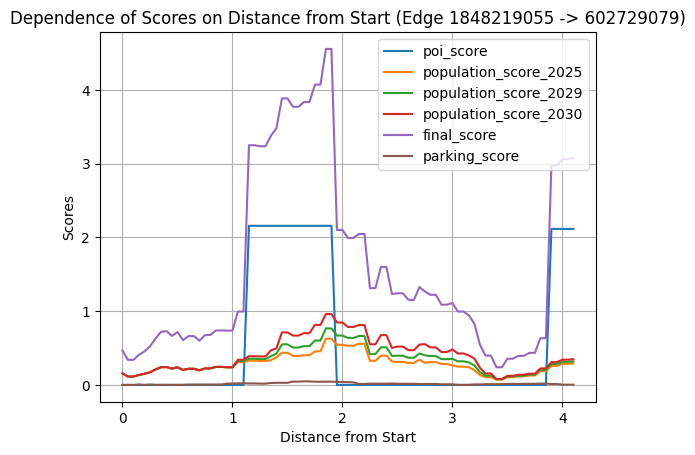

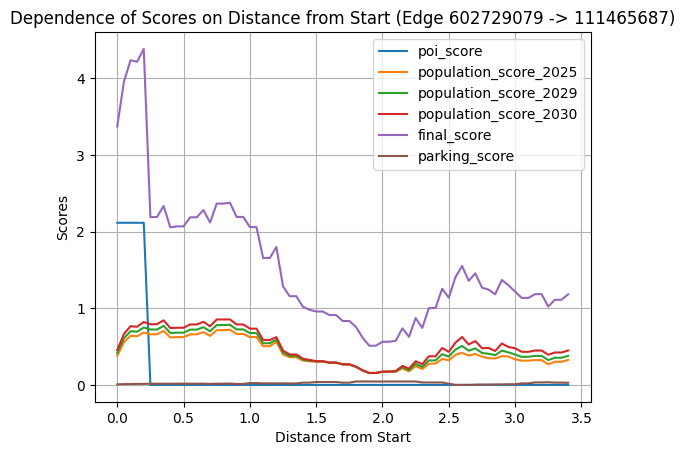

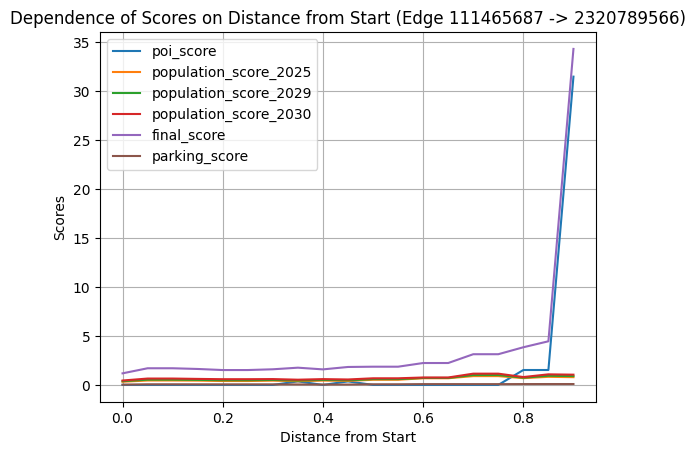

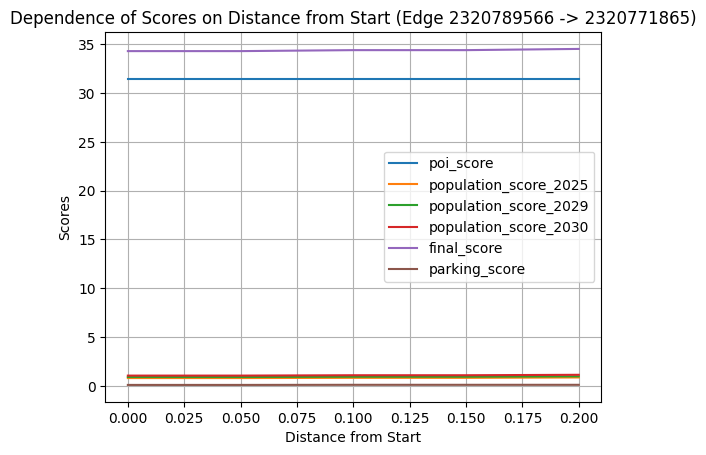

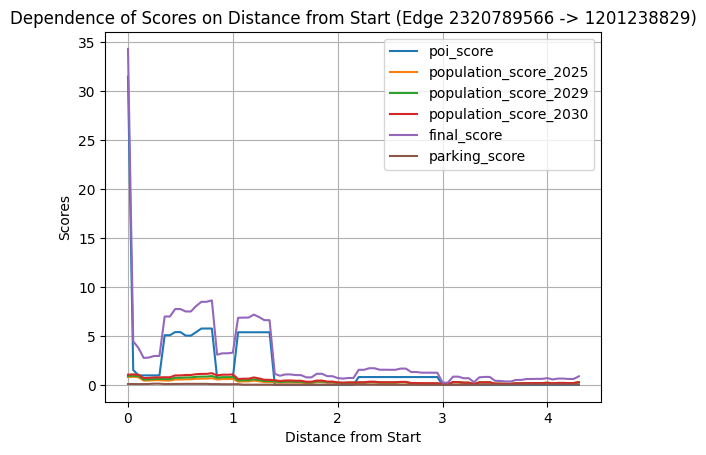

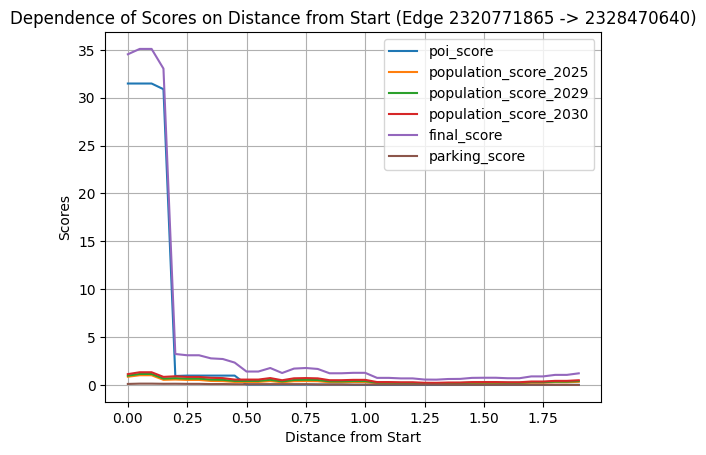

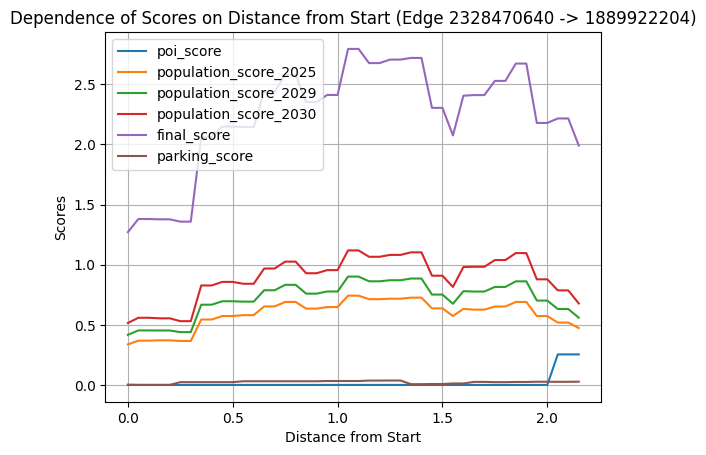

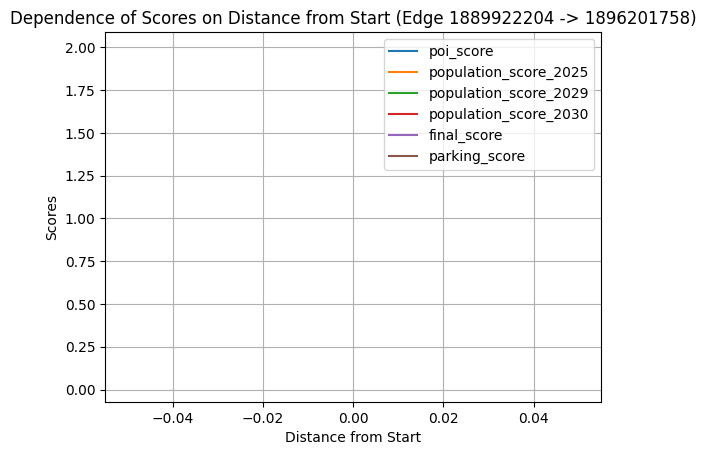

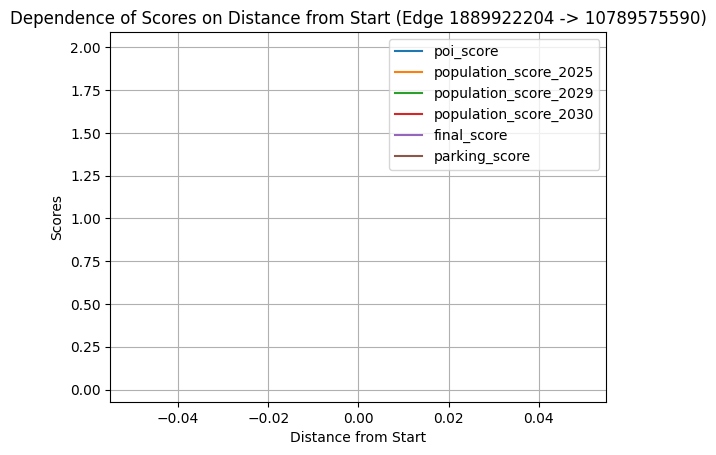

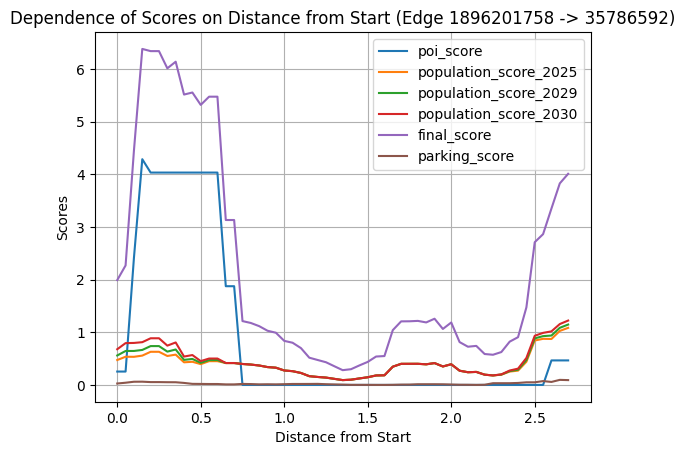

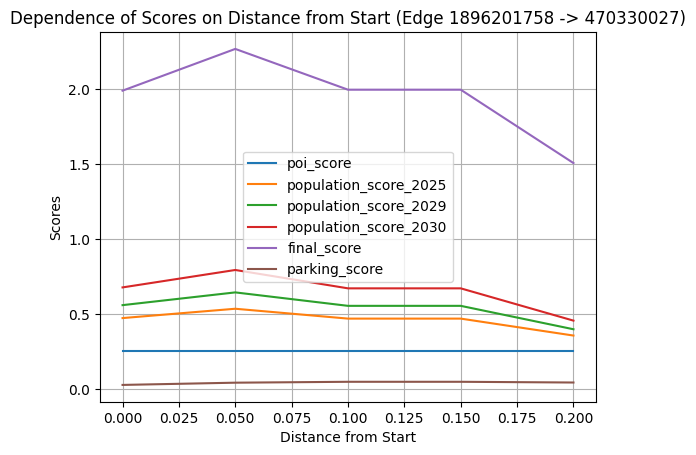

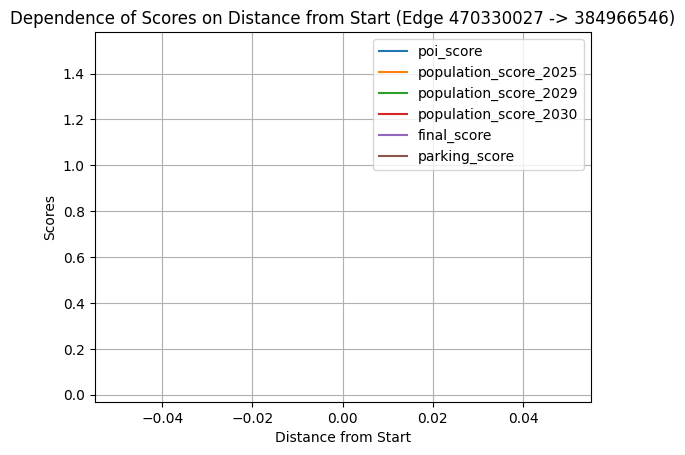

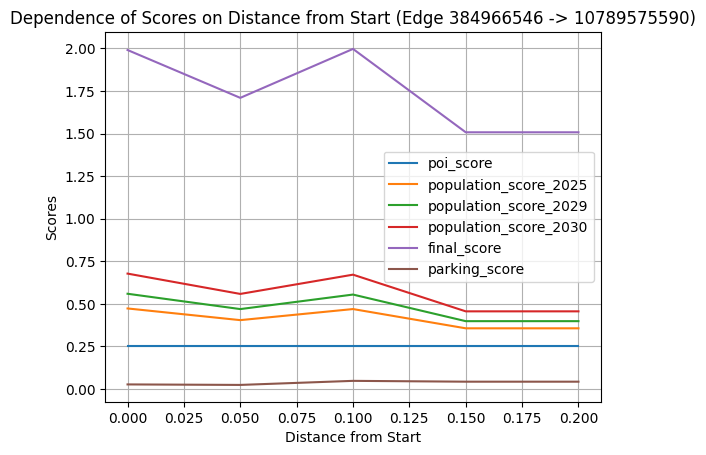

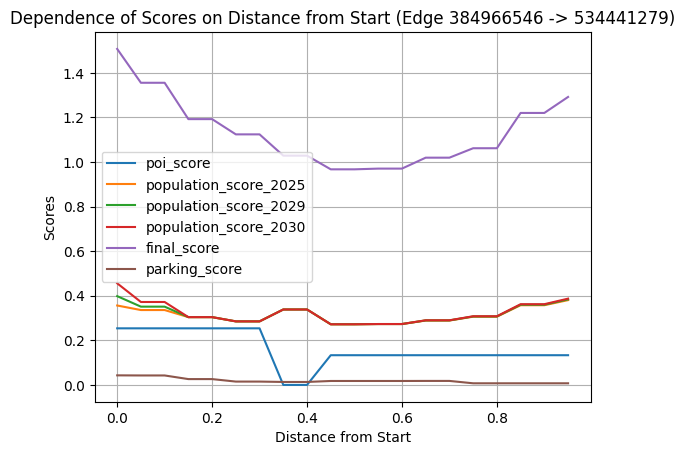

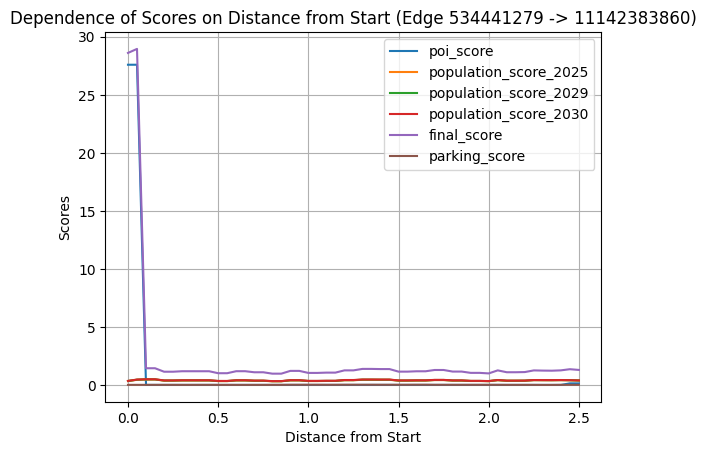

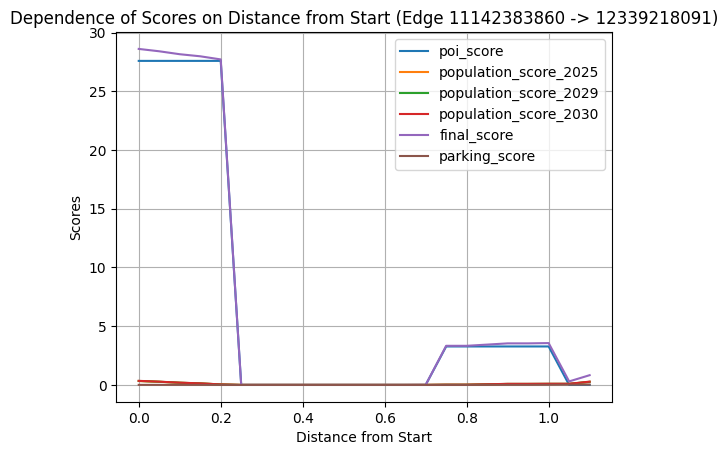

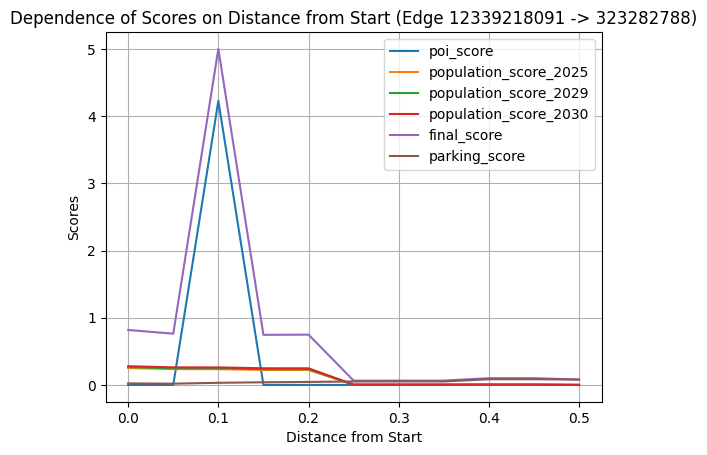

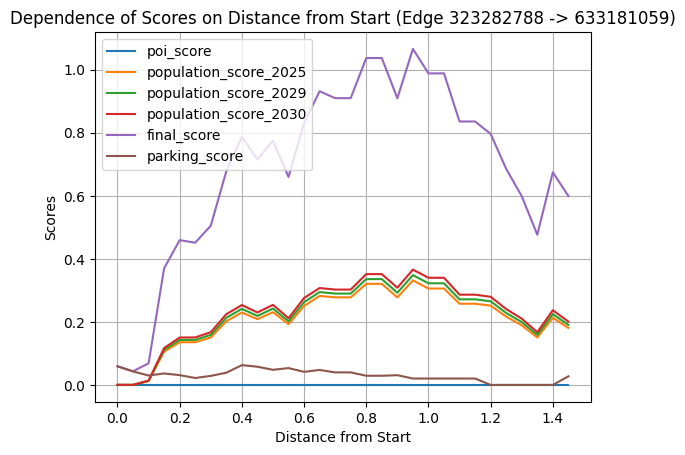

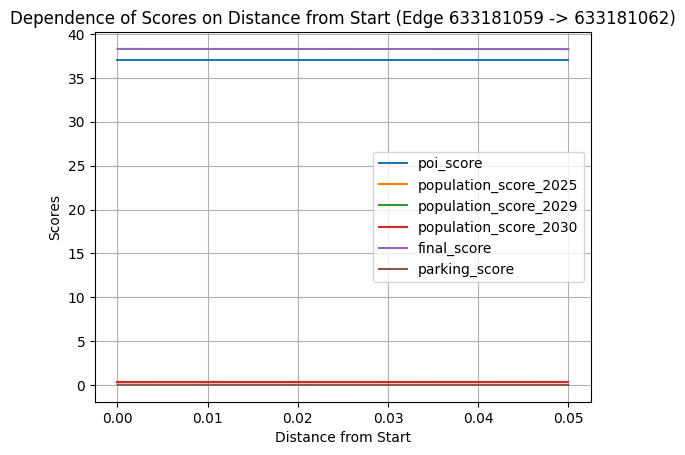

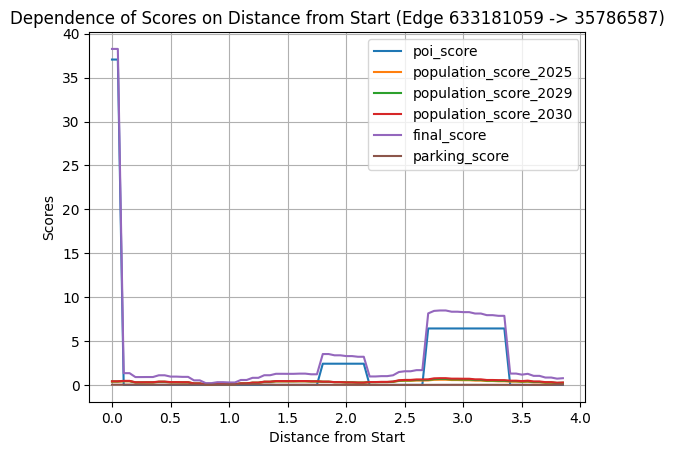

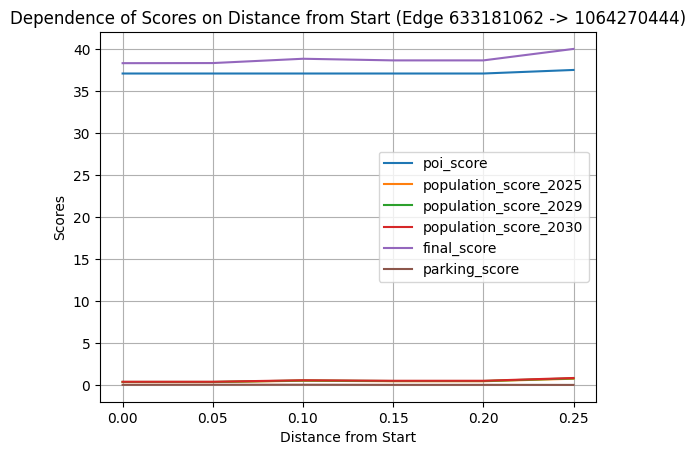

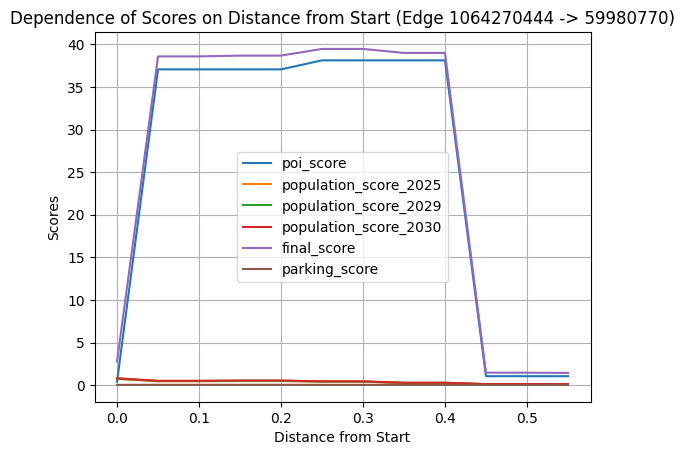

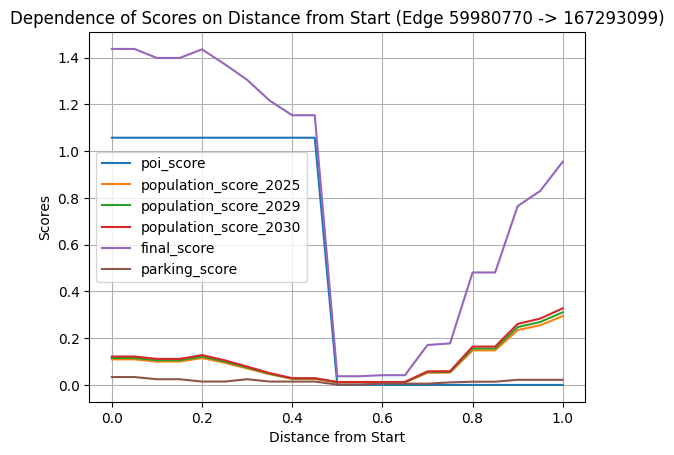

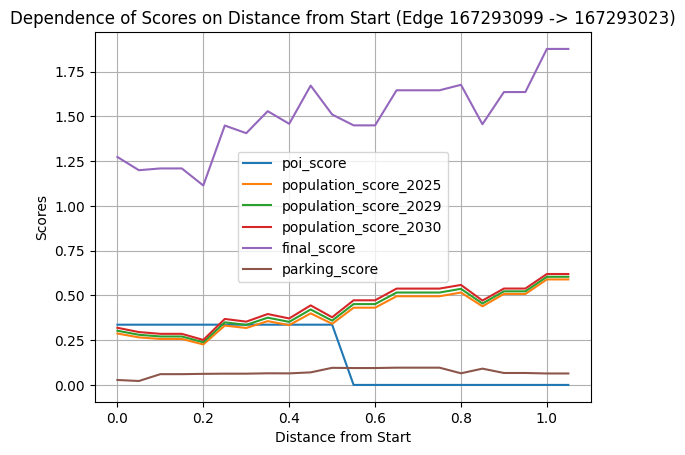

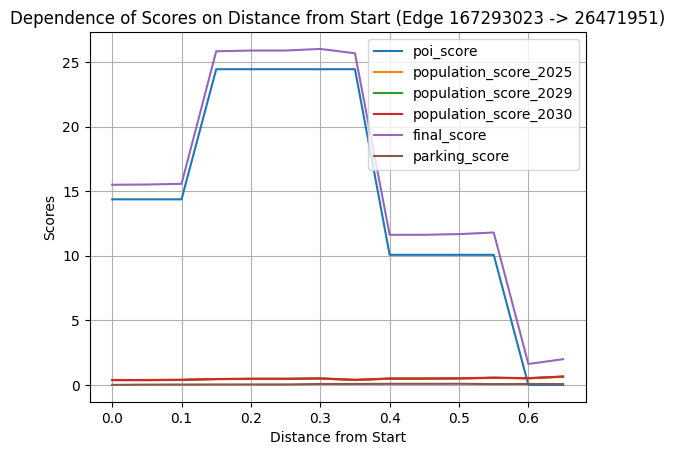

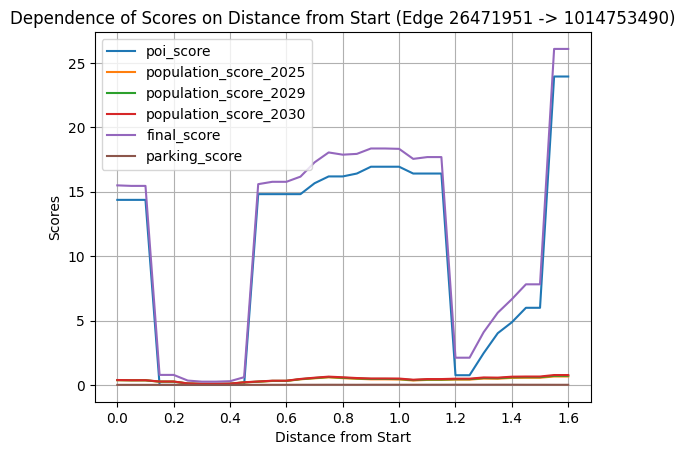

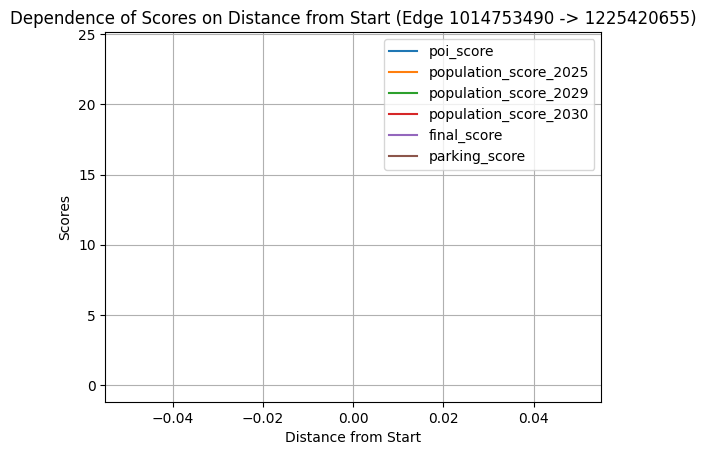

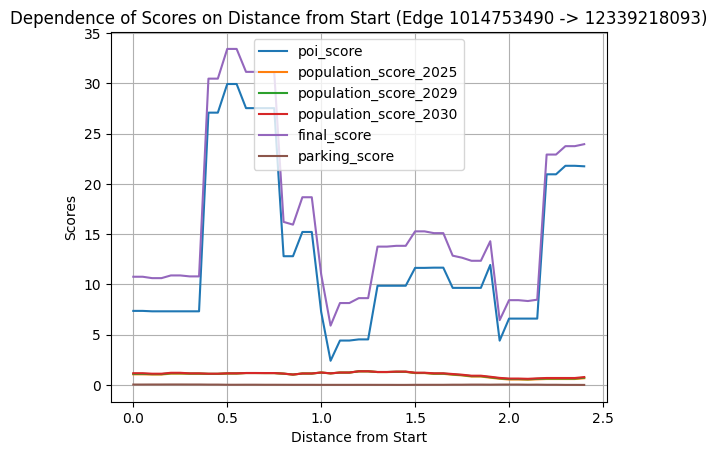

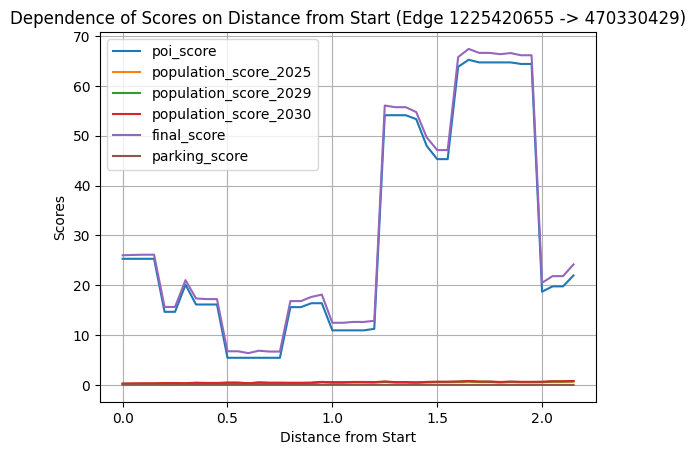

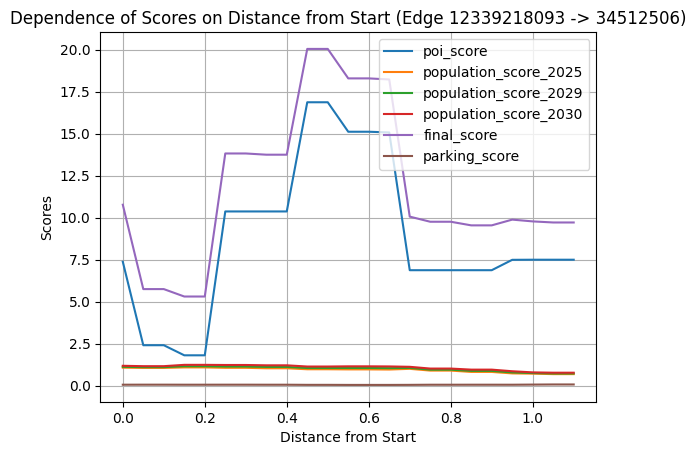

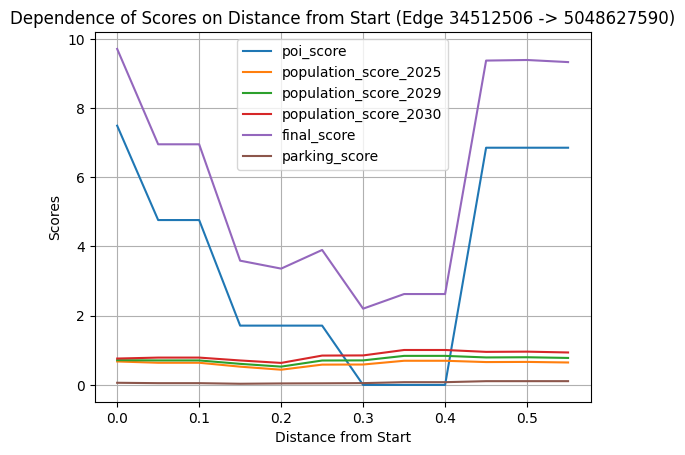

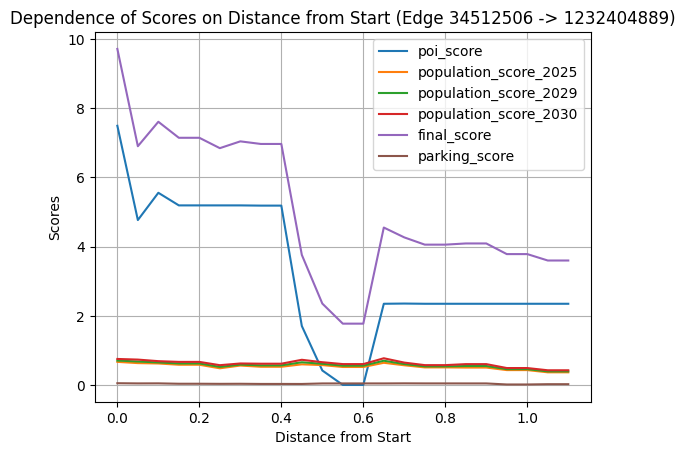

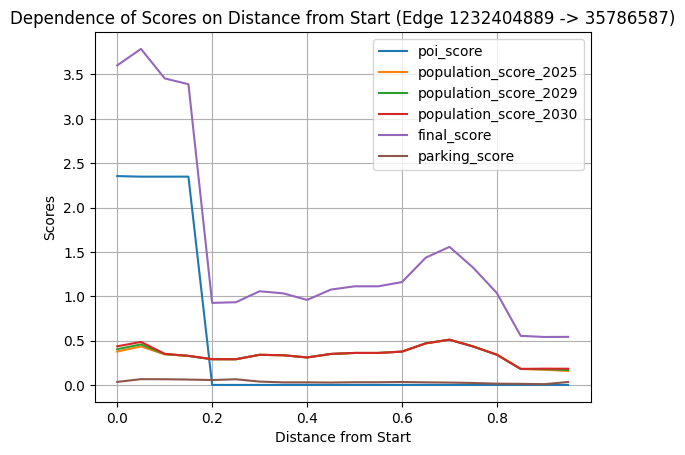

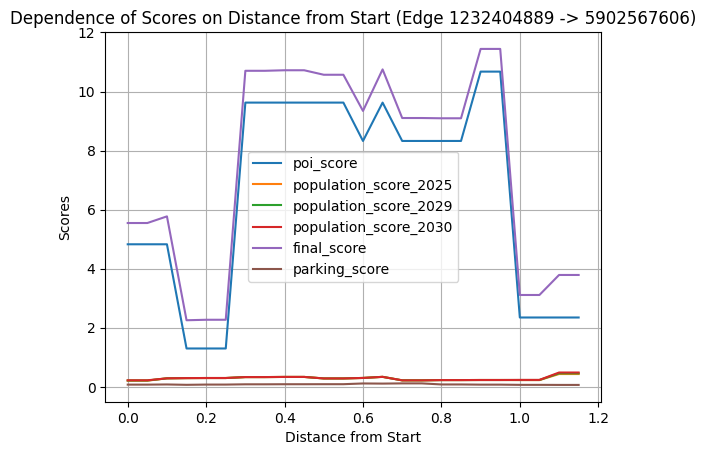

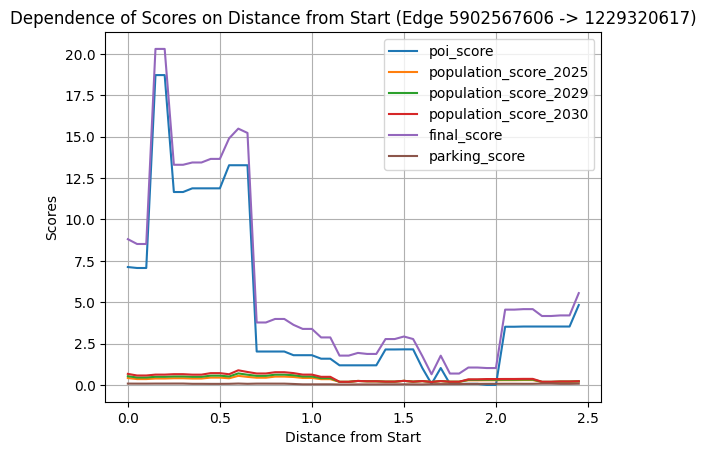

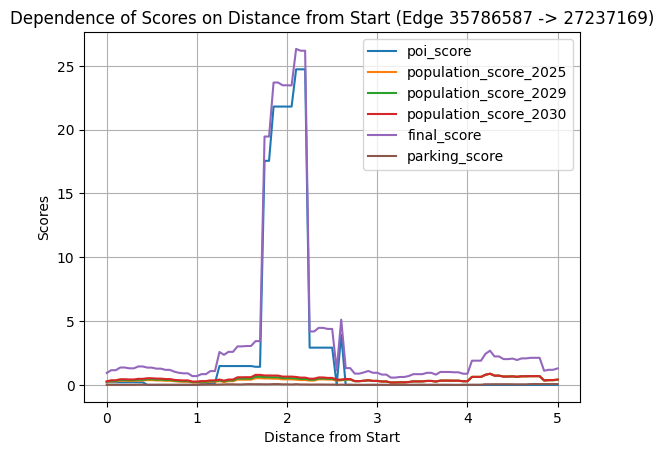

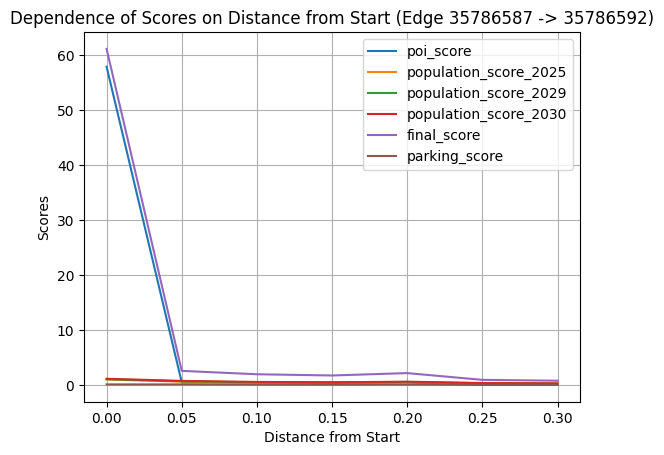

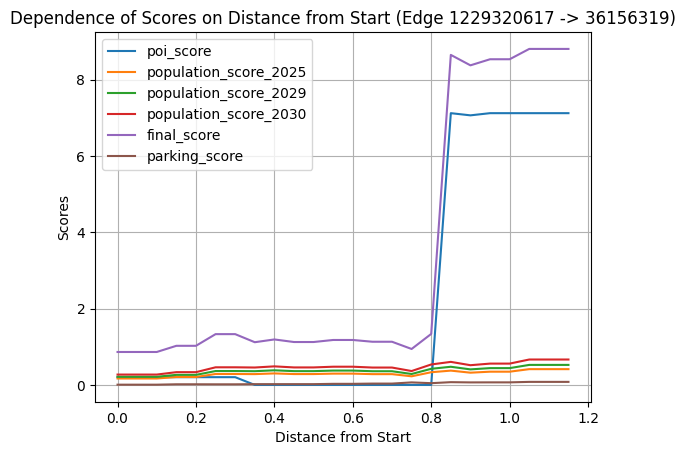

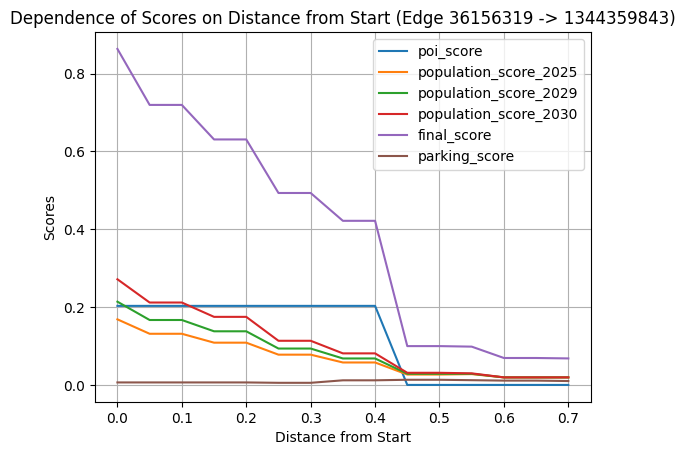

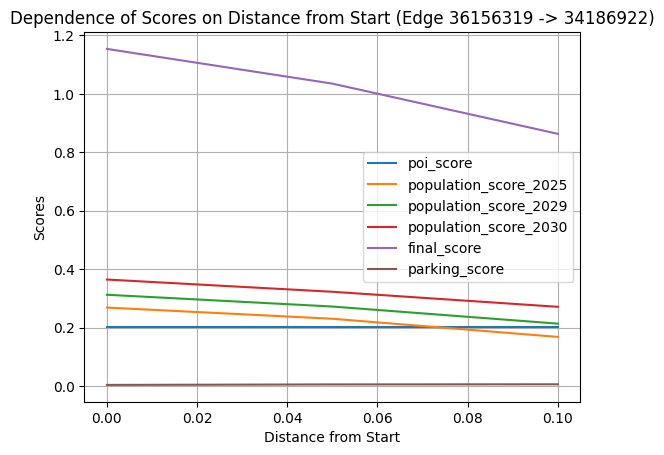

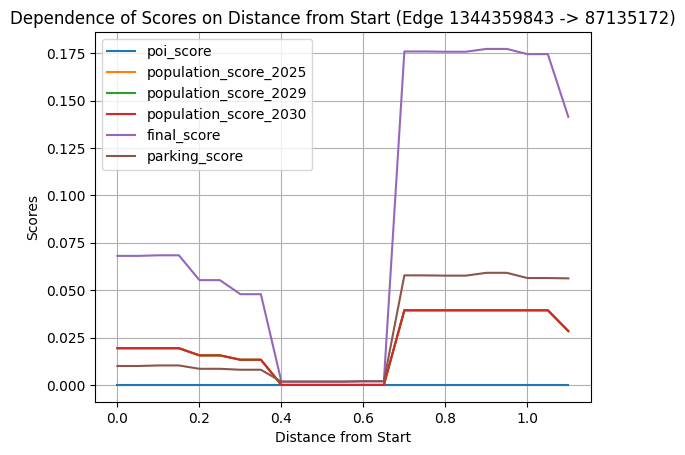

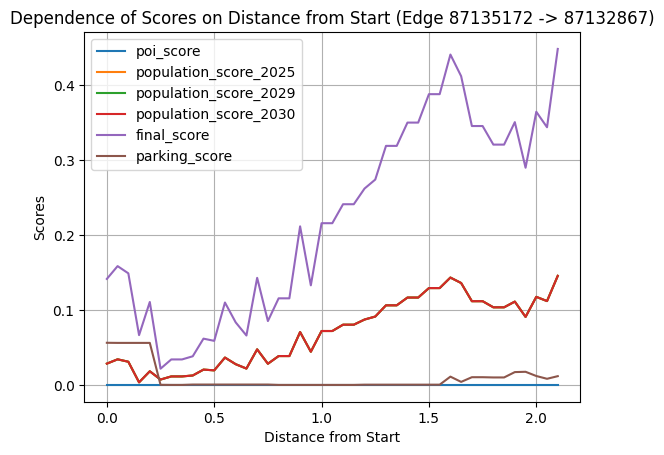

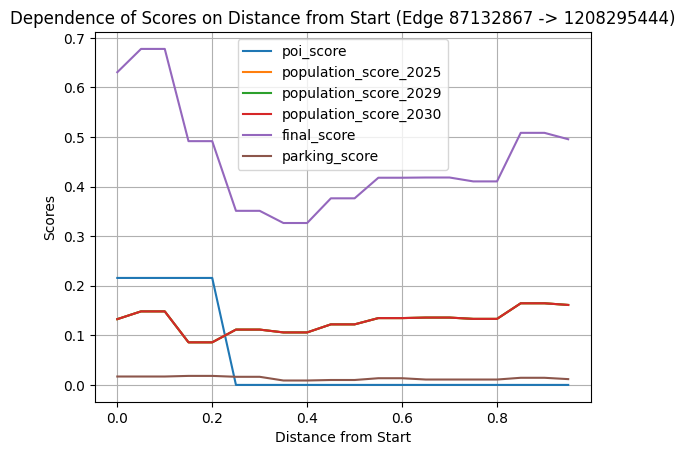

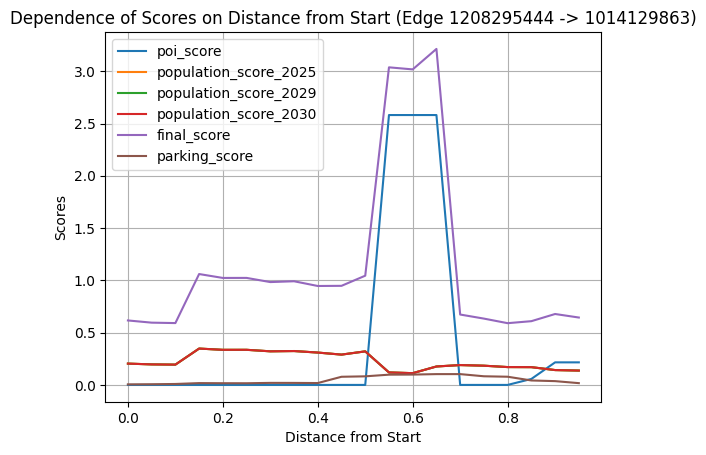

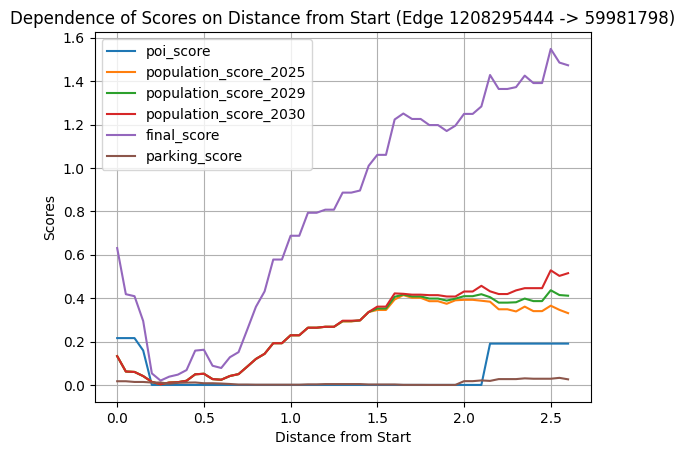

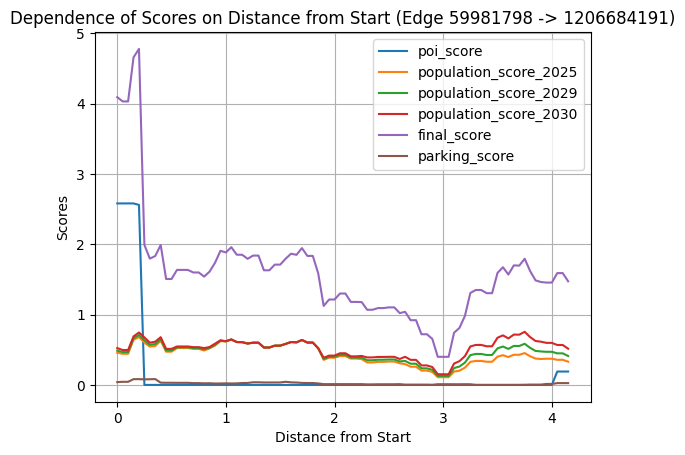

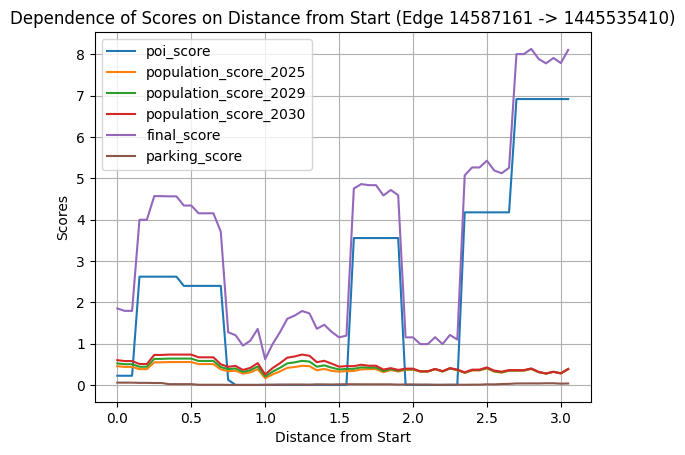

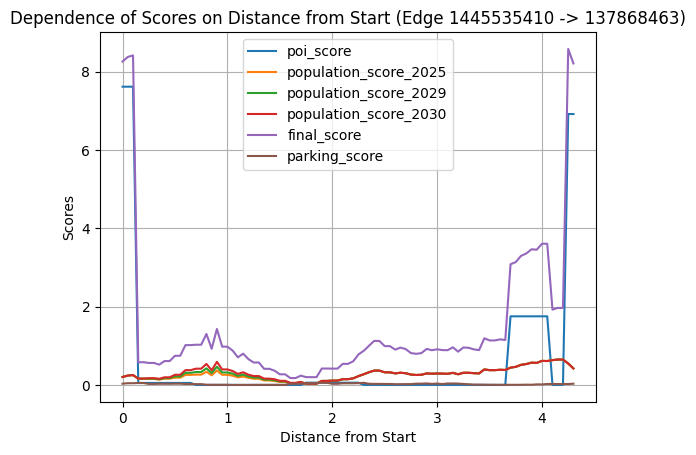

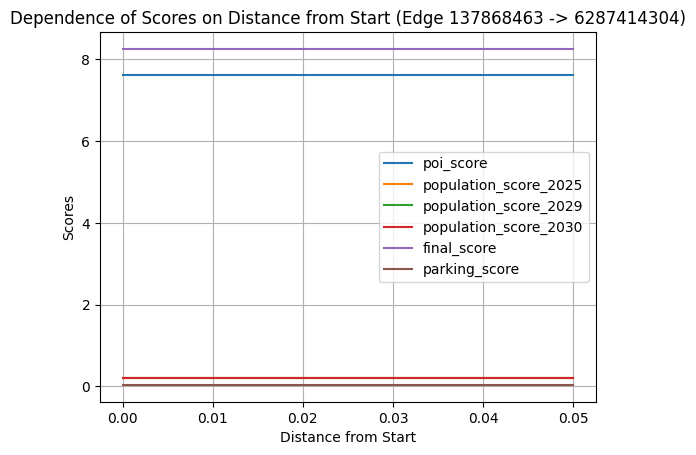

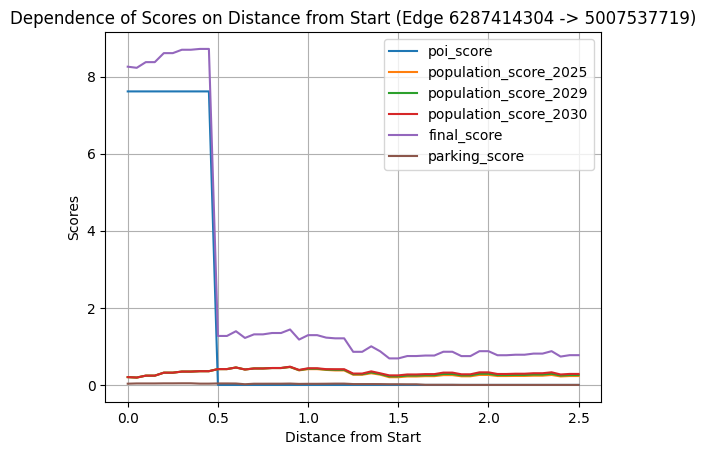

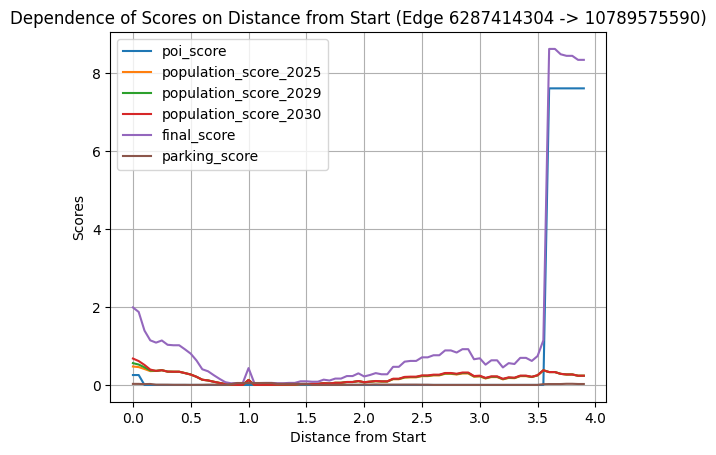

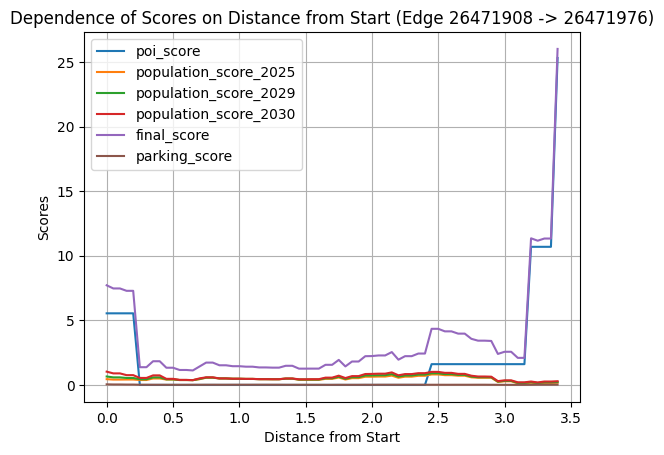

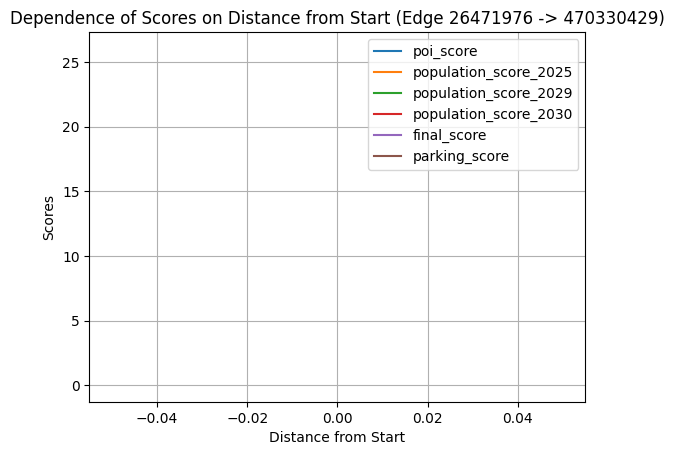

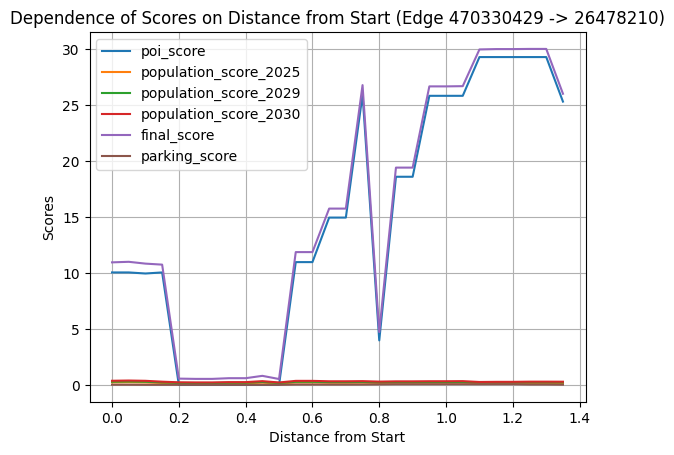

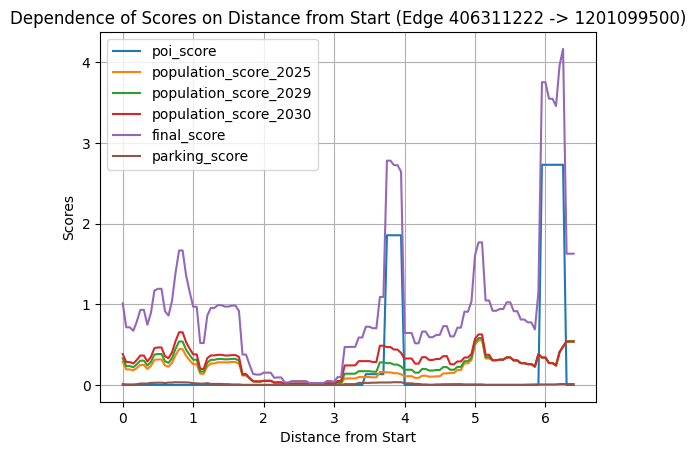

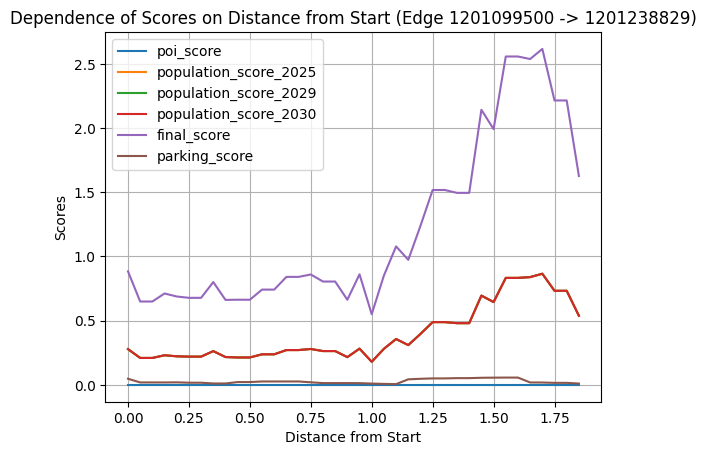

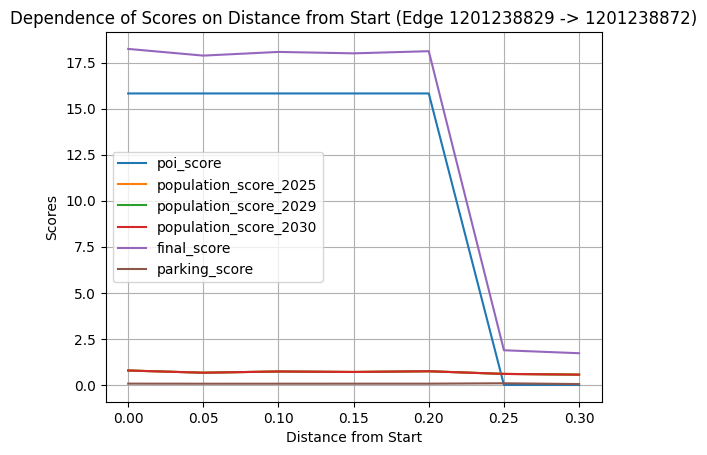

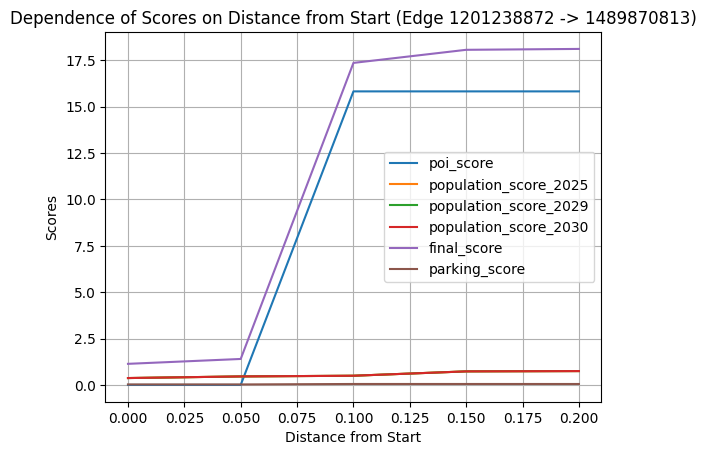

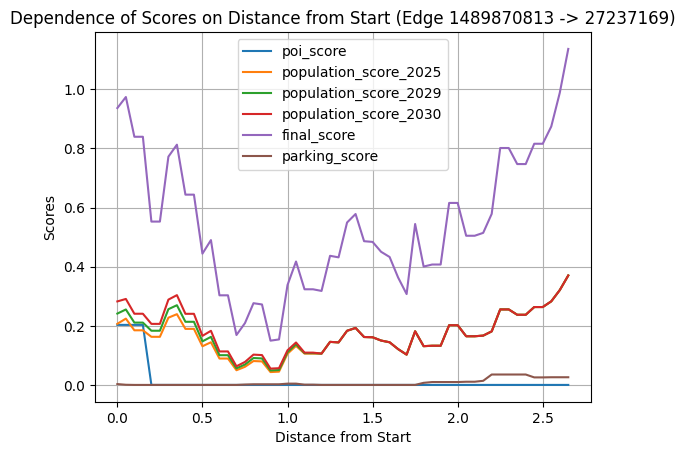

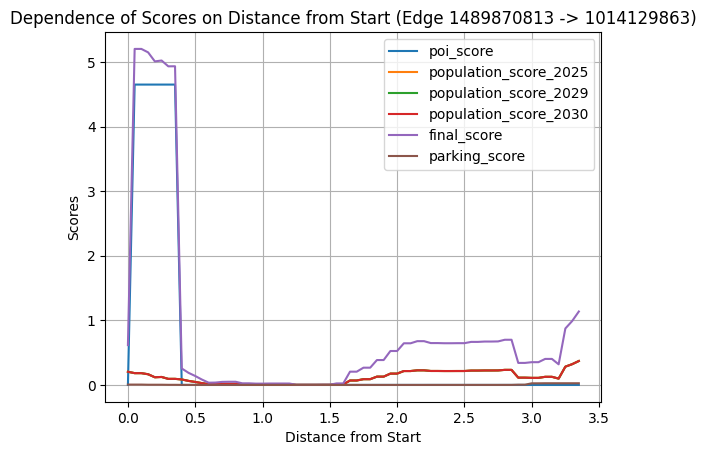

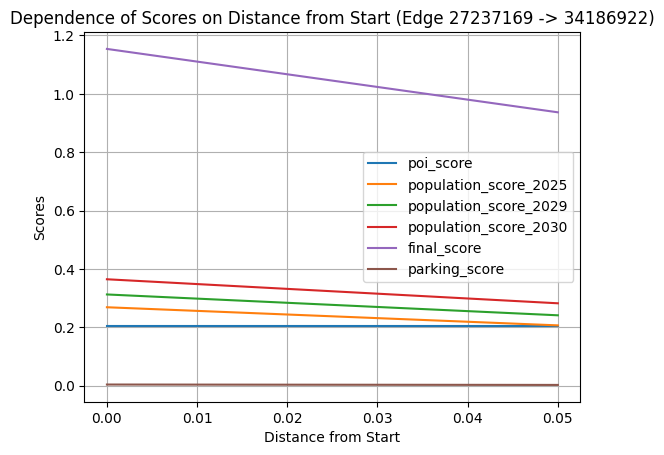

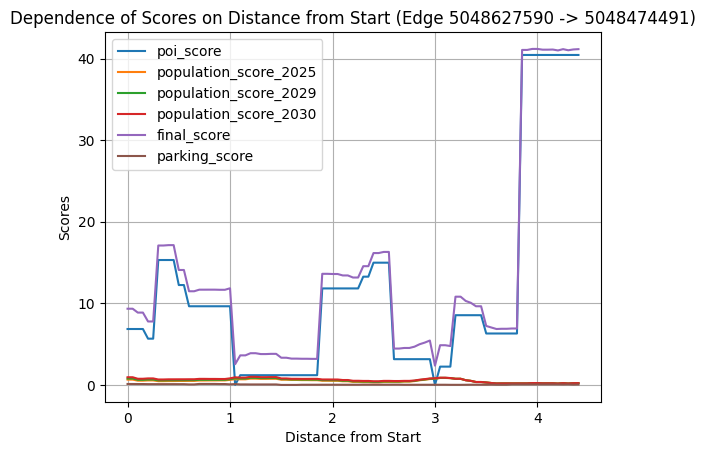

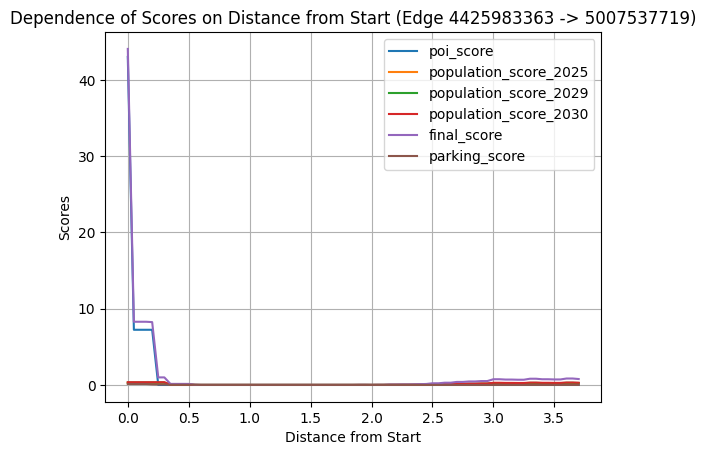

In [42]:
for from_id, to_id, edge_data in G.edges(data=True):
    score_data = edge_data['score_data']
    extracted_data = [(value['distance_from_start'], value['scores'])
                      for value in score_data]

    # Separate distances and scores
    distances = [item[0] for item in extracted_data]
    scores_dict = {key: [] for key in extracted_data[0]
                   [1].keys()}  # Initialize score categories

    # Populate scores_dict
    for _, scores in extracted_data:
        for key, value in scores.items():
            scores_dict[key].append(value)

    # Plotting
    for score_type, values in scores_dict.items():
        plt.plot(distances, values, label=score_type)

    plt.xlabel('Distance from Start')
    plt.ylabel('Scores')
    plt.title(
        f'Dependence of Scores on Distance from Start (Edge {from_id} -> {to_id})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [43]:
save_graph(G, '../data/railroad_with_scores.json')